<a href="https://colab.research.google.com/github/DigitalGoldRush/Project-2-Emotional-recognition/blob/main/emotion_recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
RANDOM_SEED = 123


In [5]:
#Faster way to upload zip files from gdrive to colab
# ID of Kaggle emotional dataset
! gdown --id 1wrwLq6DqNHLDxU18RYUPY0WcV4ZNG70P

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wrwLq6DqNHLDxU18RYUPY0WcV4ZNG70P
To: /content/emotional dataset.zip
100% 62.6M/62.6M [00:00<00:00, 176MB/s]


In [7]:
# Required to save models in HDF5 format
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# zip file opener
!pip install patool
import patoolib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.7 MB/s 


In [9]:
patoolib.extract_archive('/content/emotional dataset.zip')

patool: Extracting /content/emotional dataset.zip ...
patool: running /usr/bin/7z x -o./Unpack_23jjmc7c -- "/content/emotional dataset.zip"
patool: ... /content/emotional dataset.zip extracted to `emotional dataset' (multiple files in root).


'emotional dataset'

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [11]:
# data preparation
train_dir = '/content/emotional dataset/Training/Training'
test_dir = '/content/emotional dataset/Testing/Testing'

train_angry_dir = '/content/emotional dataset/Training/Training/Angry'
train_fear_dir = '/content/emotional dataset/Training/Training/Fear'
train_happy_dir = '/content/emotional dataset/Training/Training/Happy'
train_neutral_dir = '/content/emotional dataset/Training/Training/Neutral'
train_sad_dir = '/content/emotional dataset/Training/Training/Sad'
train_surprise_dir = '/content/emotional dataset/Training/Training/Suprise'

test_angry_dir = '/content/emotional dataset/Testing/Testing/Angry'
test_fear_dir = '/content/emotional dataset/Testing/Testing/Fear'
test_happy_dir = '/content/emotional dataset/Testing/Testing/Happy'
test_neural_dir = '/content/emotional dataset/Testing/Testing/Neutral'
test_sad_dir = '/content/emotional dataset/Testing/Testing/Sad'
test_surprise_dir = '/content/emotional dataset/Testing/Testing/Suprise'

dir_list = [train_angry_dir, train_fear_dir, train_happy_dir,
           train_neutral_dir, train_sad_dir, train_surprise_dir,
           test_angry_dir, test_fear_dir, test_happy_dir,
           test_neural_dir, test_sad_dir, test_surprise_dir]

for d in dir_list:
    print(d, len(os.listdir(d)))


/content/emotional dataset/Training/Training/Angry 3995
/content/emotional dataset/Training/Training/Fear 4097
/content/emotional dataset/Training/Training/Happy 7215
/content/emotional dataset/Training/Training/Neutral 4965
/content/emotional dataset/Training/Training/Sad 4830
/content/emotional dataset/Training/Training/Suprise 3171
/content/emotional dataset/Testing/Testing/Angry 958
/content/emotional dataset/Testing/Testing/Fear 1024
/content/emotional dataset/Testing/Testing/Happy 1774
/content/emotional dataset/Testing/Testing/Neutral 1233
/content/emotional dataset/Testing/Testing/Sad 1247
/content/emotional dataset/Testing/Testing/Suprise 831


In [12]:
# image generator

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=64,
                                                   class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                             target_size=(150,150),
                                                             batch_size=62,
                                                             class_mode='categorical')

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [13]:
# callback function

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                 restore_best_weights=True)

In [14]:
# build the model

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(6, activation='softmax')  
])

from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()
# keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [18]:
# to check if colab is connected to a GPU for faster speed
# change Notebook settings above to Runtime > Change runtime type
# need Colab Pro

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Sat Oct  1 20:57:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    38W / 300W |    523MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
# train the model

history = model.fit(train_generator,
                   epochs=10,
                   verbose=1,
                   validation_data=validation_generator,
                   callbacks=early_stopping_cb)


Epoch 1/10
442/442 [==============================] - 164s 344ms/step - loss: 1.7450 - accuracy: 0.2588 - val_loss: 1.6778 - val_accuracy: 0.2998
Epoch 2/10
442/442 [==============================] - 159s 360ms/step - loss: 1.6825 - accuracy: 0.2959 - val_loss: 1.6857 - val_accuracy: 0.3073
Epoch 3/10
442/442 [==============================] - 160s 361ms/step - loss: 1.6102 - accuracy: 0.3392 - val_loss: 1.4618 - val_accuracy: 0.4187
Epoch 4/10
442/442 [==============================] - 153s 346ms/step - loss: 1.5518 - accuracy: 0.3687 - val_loss: 1.3914 - val_accuracy: 0.4487
Epoch 5/10
442/442 [==============================] - 151s 342ms/step - loss: 1.5020 - accuracy: 0.3904 - val_loss: 1.3870 - val_accuracy: 0.4504
Epoch 6/10
442/442 [==============================] - 153s 346ms/step - loss: 1.4707 - accuracy: 0.4108 - val_loss: 1.3130 - val_accuracy: 0.4863
Epoch 7/10
442/442 [==============================] - 153s 347ms/step - loss: 1.4341 - accuracy: 0.4273 - val_loss: 1.2676 -

In [30]:
# save the model to g-drive because files are discarded on colab after a period of time

# model.save('facial_reco_base_model.h5')

model.save("/content/drive/MyDrive/Colab Notebooks/Project 2_ Emotion Recognition/facial_reco_base_model.h5")



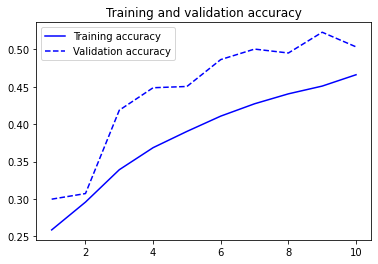

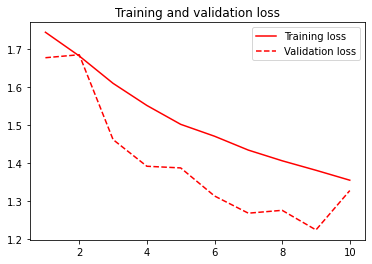

In [31]:
# plot accuracy and loss

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# accuracy

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# loss

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()